<a href="https://colab.research.google.com/github/kritisingh24/joeynmt/blob/main/IITB_Baseline_and_Active_Learning_EN_HI_11Sep_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Active Learning for Neural Machine Translation
In this notebook, we'll train a Machine Translation model with Active Learning approach. It covers following topics:
1. Environmental setup
2. Data preparation
3. Configuration
4. Model training
5. Evaluation

Author: Kriti Singh

Last update: 16. Sept, 2022

> ⚠ **Important:** Before you start, set runtime type to GPU.

In [1]:
!pip install -q subword-nmt
!pip install -q wordpiece
!pip install -q opustools-pkg
!pip install -q sacremoses
!pip install -q swifter
!!pip install -q matplotlib==3.1.3
!pip install -q sentencepiece
!pip install -q sacrebleu
!pip install -q wordcloud
## clone indic nlp resources repo
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
## install indic nlp library
!pip install -q indic-nlp-library
!pip install -q datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 80 kB 4.0 MB/s 
     |████████████████████████████████| 880 kB 4.7 MB/s 
     |████████████████████████████████| 830 kB 4.7 MB/s 
     |████████████████████████████████| 281 kB 67.7 MB/s 
     |████████████████████████████████| 1.6 MB 58.3 MB/s 
     |████████████████████████████████| 1.3 MB 4.7 MB/s 
     |████████████████████████████████| 116 kB 4.7 MB/s 
Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 139 (delta 2), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (139/139), 149.77 MiB | 40.92 MiB/s, done.
Resolving deltas: 100% (53/53), done.
     |████████████████████████████████| 40 kB 3.7 MB/s 
     |████████████████████████████████| 2.8 MB 8.0 MB/s 
     |████████████

Make sure that you have a compatible PyTorch version.

In [2]:
import torch
print(torch.__version__)

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.version.cuda)

1.12.1+cu113
True
1
11.3


## Data Preparation

### Download
We'll use English - Hindi translations from the [IIT Bombay English-Hindi Corpus](https://www.cfilt.iitb.ac.in/iitb_parallel/) collection ([CC-BY 4.0 NC](https://creativecommons.org/licenses/by-nc/4.0/)).

[IITB-English-Hindi Parallel Corpus ](https://huggingface.co/datasets/cfilt/iitb-english-hindi) corpus is available in Huggingface's datasets library.


The  IIT Bombay English-Hindi dataset on HuggingFace Hub has dev and test split, size of both is very small(dev 520 and Test 2507). So let's split the data manually and save it locally.

In [3]:
import pandas as pd
from google.colab import drive
import numpy as np
import re, os, string
import swifter
from datasets import load_dataset
from pathlib import Path
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import math

drive.mount('/content/drive')
local_path = '/content/drive/MyDrive'
# local_path = str(Path().resolve())

DATASIZE = 100 # this is translated to .25 of all the data

# clone our base repository for active learning
!git clone https://github.com/kritisingh24/joeynmt.git
%cd joeynmt

# created a dummy list of all bad hindi words which were mixing with voab at later stages.
!wget https://gist.githubusercontent.com/kritisingh24/6073f5e1f45b00b348f9378b7910373e/raw/c07f8e96fba562b7401d78dd5c2397a738bf496e/unwanted_vocab.hi
!wget https://raw.githubusercontent.com/joeynmt/joeynmt/main/scripts/build_vocab.py

# creating directories
parent_dir = f"{local_path}/data/datasets_enhi"
data_dir = f"{local_path}/data/datasets_enhi_{DATASIZE}"
model_dir = f"{local_path}/models/v1_enhi_{DATASIZE}_transformer"
log_dir = f"{local_path}/logs/log_enhi_{DATASIZE}"
!mkdir -p {log_dir}
!mkdir -p {data_dir}
!mkdir -p {model_dir}

Mounted at /content/drive
Cloning into 'joeynmt'...
remote: Enumerating objects: 4112, done.
remote: Counting objects: 100% (1161/1161), done.
remote: Compressing objects: 100% (515/515), done.
remote: Total 4112 (delta 769), reused 949 (delta 639), pack-reused 2951
Receiving objects: 100% (4112/4112), 25.96 MiB | 21.65 MiB/s, done.
Resolving deltas: 100% (2799/2799), done.
/content/joeynmt
--2022-09-16 15:43:35--  https://gist.githubusercontent.com/kritisingh24/6073f5e1f45b00b348f9378b7910373e/raw/c07f8e96fba562b7401d78dd5c2397a738bf496e/unwanted_vocab.hi
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538 [text/plain]
Saving to: ‘unwanted_vocab.hi’

unwanted_vocab.hi   100%[===================>]     538  --.-KB/s    in 0s      

2022-09-16 15:43:36 (18

In [ ]:
def create_df(src_file, tgt_file):
  """
  reads from local files
  useful if we have source and target sentences read from file
  """
  src = []
  tgt = []

  with open(src_file, 'r') as src_, open(tgt_file, 'r') as tgt_:
    src_lines = src_.readlines()
    tgt_lines = tgt_.readlines()
  assert len(src_lines) == len(tgt_lines) 
  for line_index in range(len(src_lines)):
    src.append(src_lines[line_index].strip('\n'))
    tgt.append(tgt_lines[line_index].strip('\n'))

  df = pd.DataFrame({'en': src,
                     'hi': tgt})

  return df

In [ ]:
# reading the source and target IITB english Hindi Corpus from HuggingFace Hub
dataset_iitb = load_dataset("cfilt/iitb-english-hindi")

In [ ]:
# Formatting all the test train and validation data in a single dataframe.
df_iitb_train = pd.DataFrame( dataset_iitb['train']['translation'])
df_iitb_train['type']="train"
df_iitb_train['data_src'] ="iitb"
df_iitb_test = pd.DataFrame( dataset_iitb['test']['translation'])
df_iitb_test['type']="test"
df_iitb_test['data_src'] ="iitb"
df_iitb_val = pd.DataFrame( dataset_iitb['validation']['translation'])
df_iitb_val['type']="val"
df_iitb_val['data_src'] ="iitb"
df_datasets = pd.concat([df_iitb_train,df_iitb_test,df_iitb_val])
df_datasets.reset_index(inplace=True)

In [ ]:
df_datasets

,index,en,hi,type,data_src
0,0,Give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,train,iitb
1,1,Accerciser Accessibility Explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक,train,iitb
2,2,The default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,train,iitb
3,3,The default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,train,iitb
4,4,A list of plugins that are disabled by default,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,train,iitb
...,...,...,...,...,...
1662105,515,"The former Deputy Chief Minister, Narhari Amin...",विस चुनाव से पहले कांग्रेस छोड़ भाजपा में आए प...,val,iitb
1662106,516,This Ministry expansion is being seen as Modi'...,इस मंत्रिमंडल विस्तार को मोदी की लोकसभा चुनाव ...,val,iitb
1662107,517,He has been travelling around a lot to promote...,वह लंबे समय से राजनीतिक प्रवास कर रहे हैं।,val,iitb
1662108,518,"After doing a tour of the five states, he will...",पांच राज्यों के विस चुनाव बाद और ज्यादा आक्राम...,val,iitb


In [ ]:
df_datasets.shape

(1662110, 5)

### Data Preprocessing

Here we perform cleaning operation on source and target language sentences. We have performed following operations.
- punctuations removal
- function to replace devanagari numbers into english
- function to remove bad characters
- function to replace unfinished quote
- lower case
- Normalizing text using IndicNormalizerFactory

In [ ]:
from sacremoses import MosesTokenizer
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
#&quot;   "  &amp; quot ; &amp; quot ; &amp; quot ;
#   &amp; quot ; &amp; quot ; &amp; quot ; The missile trajectory was tracked by DRDO radars , electro-optical tracking systems and telemetry stations located along the coast of Odisha , &amp; quot ; &amp; quot ; they said . &amp; quot ;
os.environ["INDIC_RESOURCES_PATH"] = "indic_nlp_resources"

## punctuations except single quotes, double quotes, comma, full stop, hypen and colon
punc = string.punctuation
punc = punc.replace(".", "")
punc = punc.replace(",", "")
punc = punc.replace("'", "")
punc = punc.replace('"', "")
punc = punc.replace("-", "")
punc = punc.replace(":", "")
## unwated punctuation chars
exclude = set(punc)

## function to replace devanagari numbers with english numbers
def replace_hi_en_num(input_text):
  hi_en_num_map = {"०":"0", "१":"1", "२":"2", "३":"3", "४": "4", "५":"5", "६":"6", "७":"7", "८":"8", "९":"9", "।":"."}
  estring = ""
  for char in input_text:
    if char in hi_en_num_map:
      estring = estring + hi_en_num_map[char]
    else:
      estring = estring + char
  return estring

## function to remove bad characters
def remove_bad_chars(input_text):
  with open('unwanted_vocab.hi') as f:
    lines = f.readlines()
  bad_char = [x.replace("\n", "") for x in lines]
  # print(bad_char)
  for i in bad_char :
    input_text = input_text.replace(i, '')
  return input_text


## function to replace unfinished quote e.g. he said, "tomorrow is sunny day. -> he said, tomorrow is sunny day
def replace_unfinished_quotes(input_text):
  if input_text.count('"') == 1:
    input_text = input_text.replace('"', "")
  return input_text

## function to clean english sentences
def clean_en(input_text):
  ## lower case
  input_test = input_text.lower()

  ## remove text between braces, either () or []
  input_text = re.sub("\[.*?\]","", input_text)
  input_text = re.sub("\(.*?\)","", input_text)

  ## remove unwated punctuations
  input_text = ''.join(ch for ch in input_text if ch not in exclude)

  s =  r'[[\]\@_\\!#$%^&*()<>?/\|}{~:]'
  input_text = re.sub(s, '', input_text)

  ## remove extra spaces
  input_text = input_text.strip()
  input_text = re.sub(" +", " ", input_text)
  ## remove space between full stop
  input_text = input_text.replace(" .", ".")

  ## remove unwated punctuations
  input_text = ''.join(ch for ch in input_text if ch not in exclude)

  ## remove unfinished quotes
  input_text = replace_unfinished_quotes(input_text)

  ## remove space before hypen if exists
  input_text = input_text.replace(" -", "-")

  ## return clean text
  return " ".join(input_text.split())

## function to clean hindi sentences
def clean_hi(input_text):

  ## remove text between braces, either () or [] and &;
  input_text = re.sub("\[.*?\]","", input_text)
  input_text = re.sub("\(.*?\)","", input_text)

  s =  r'[[\]\@_\\!#$%^&*()<>?/\|}{~:]'
  input_text = re.sub(s, '', input_text)
  #remove bad character
  input_text = remove_bad_chars(input_text)

  ## Normalizing text
  factory = IndicNormalizerFactory()
  normalizer = factory.get_normalizer("hi", remove_nuktas = False)
  input_text = normalizer.normalize(input_text)

  ## convert hindi numbers to english
  input_text_tokens = input_text.split()
  input_text = [replace_hi_en_num(word) for word in input_text_tokens]
  input_text = " ".join(input_text)

  ## remove unwated punctuations
  input_text = ''.join(ch for ch in input_text if ch not in exclude)

  ## remove unfinished quotes
  input_text = replace_unfinished_quotes(input_text)

  ## remove space before hypen if exists
  input_text = input_text.replace(" -", "-")

  ## remove extra spaces
  input_text = input_text.strip()
  input_text = re.sub(" +", " ", input_text)

  ## return clean text
  return " ".join(input_text.split())

# keep only char between a and z
def clean_english_text(input_text):
  clean_sentence = list()
  for words in input_text.lower().split(" "):
    clean_word = ''.join([char if ord('a') <= ord(char) <= ord('z') or ord(char) == ord('.') or ord(char) == ord(',') or  ord(char) == ord('?') else '' for char in words])
    clean_sentence.append(clean_word)
  return " ".join(clean_sentence)

# keep only char of devanagari
def clean_hindi_text(input_text):
  # input_text = """"उन्होंने कहा, ""बाबू रघुवंश प्रसाद जी ने भी ग २ |"""
  clean_sentence = list()
  for words in input_text.split(" "):
    clean_word = ''.join([char if ord(u'\u0900') <= ord(char) <= ord(u'\u097F') or ord(char) == ord('|') or ord(char) == ord(',') or  ord(char) == ord('?') else '' for char in words])
    clean_sentence.append(clean_word)
  return " ".join(clean_sentence)

In [ ]:
df_datasets['clean_en_sent'] = df_datasets['en'].swifter.apply(clean_english_text)
df_datasets['clean_hi_sent'] = df_datasets['hi'].swifter.apply(clean_hindi_text)

# ℹ️ saving CSV  "clean_sent.csv"
df_datasets[['clean_en_sent','clean_hi_sent']].to_csv(data_dir+"/clean_sent.csv",index=False)

Pandas Apply:   0%|          | 0/1662110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1662110 [00:00<?, ?it/s]

In [ ]:
df_datasets

,index,en,hi,type,data_src,clean_en_sent,clean_hi_sent
0,0,Give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,train,iitb,give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
1,1,Accerciser Accessibility Explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक,train,iitb,accerciser accessibility explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक
2,2,The default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,train,iitb,the default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लगइन खाका
3,3,The default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,train,iitb,the default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका
4,4,A list of plugins that are disabled by default,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,train,iitb,a list of plugins that are disabled by default,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...
...,...,...,...,...,...,...,...
1662105,515,"The former Deputy Chief Minister, Narhari Amin...",विस चुनाव से पहले कांग्रेस छोड़ भाजपा में आए प...,val,iitb,"the former deputy chief minister, narhari amin...",विस चुनाव से पहले कांग्रेस छोड़ भाजपा में आए प...
1662106,516,This Ministry expansion is being seen as Modi'...,इस मंत्रिमंडल विस्तार को मोदी की लोकसभा चुनाव ...,val,iitb,this ministry expansion is being seen as modis...,इस मंत्रिमंडल विस्तार को मोदी की लोकसभा चुनाव ...
1662107,517,He has been travelling around a lot to promote...,वह लंबे समय से राजनीतिक प्रवास कर रहे हैं।,val,iitb,he has been travelling around a lot to promote...,वह लंबे समय से राजनीतिक प्रवास कर रहे हैं।
1662108,518,"After doing a tour of the five states, he will...",पांच राज्यों के विस चुनाव बाद और ज्यादा आक्राम...,val,iitb,"after doing a tour of the five states, he will...",पांच राज्यों के विस चुनाव बाद और ज्यादा आक्राम...


In [ ]:
df_datasets.shape

(1662110, 7)

In [ ]:
df_datasets = df_datasets[['clean_en_sent','clean_hi_sent']]

### Data Tokenisation
We are using Moses Tokenizer for english language and indic tokenize for hindi language to tokenise our cleaned dataset.

In [ ]:
mt = MosesTokenizer(lang='en')
def tokenize_en(input_text):
  return mt.tokenize(input_text, return_str=True)

def tokenize_hi(input_text):
  if isinstance( input_text, str):
    return " ".join(indic_tokenize.trivial_tokenize(input_text))
  return input_text

In [ ]:
# ℹ️ Loading CSV  "clean_sent.csv"
df_datasets = pd.read_csv(data_dir+"/clean_sent.csv") 

df_datasets['clean_en_tok'] = df_datasets['clean_en_sent'].swifter.apply(tokenize_en)
df_datasets['clean_hi_tok'] = df_datasets['clean_hi_sent'].swifter.apply(tokenize_hi)

# ℹ️ saving CSV  "tok_sent.csv"
df_datasets[['clean_en_tok','clean_hi_tok']].to_csv(data_dir+"/tok_sent.csv",index=False)

Pandas Apply:   0%|          | 0/1662110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1662110 [00:00<?, ?it/s]

In [ ]:
df_datasets

,clean_en_sent,clean_hi_sent,clean_en_tok,clean_hi_tok
0,give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
1,accerciser accessibility explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक,accerciser accessibility explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक
2,the default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लगइन खाका,the default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लगइन खाका
3,the default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका,the default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका
4,a list of plugins that are disabled by default,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...,a list of plugins that are disabled by default,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...
...,...,...,...,...
1662105,"the former deputy chief minister, narhari amin...",विस चुनाव से पहले कांग्रेस छोड़ भाजपा में आए प...,"the former deputy chief minister , narhari ami...",विस चुनाव से पहले कांग्रेस छोड़ भाजपा में आए प...
1662106,this ministry expansion is being seen as modis...,इस मंत्रिमंडल विस्तार को मोदी की लोकसभा चुनाव ...,this ministry expansion is being seen as modis...,इस मंत्रिमंडल विस्तार को मोदी की लोकसभा चुनाव ...
1662107,he has been travelling around a lot to promote...,वह लंबे समय से राजनीतिक प्रवास कर रहे हैं।,he has been travelling around a lot to promote...,वह लंबे समय से राजनीतिक प्रवास कर रहे हैं ।
1662108,"after doing a tour of the five states, he will...",पांच राज्यों के विस चुनाव बाद और ज्यादा आक्राम...,"after doing a tour of the five states , he wil...",पांच राज्यों के विस चुनाव बाद और ज्यादा आक्राम...


In [ ]:
df_datasets.shape

(1662110, 4)

In [ ]:
df_datasets = df_datasets[['clean_en_tok','clean_hi_tok']]

### Data Cleaning and Alignment
This is a very important step in terms of machine translations, here we make sure that our parallel corpus is indeed aligned and there are no missing sentences in either of the languages.

In [7]:
def return_sent_len(input_text):
  """
  return sentence length, as the data is tokenised, we have to disregard any acceptable punctutions.
  """
  return len(str(input_text).replace(' .','').replace(' ,','').replace(' ।','')\
             .replace('.','').replace(',','').replace('।','').split(" "))

In [ ]:
# ℹ️ Loading CSV  "tok_sent.csv"
df_datasets = pd.read_csv(data_dir+"/tok_sent.csv") 

In [ ]:
df_datasets['en_tok_len'] = df_datasets['clean_en_tok'].swifter.apply(return_sent_len)
df_datasets['hi_tok_len'] = df_datasets['clean_hi_tok'].swifter.apply(return_sent_len)
# # C = np.where(cond, A, B) 
# df_datasets['same_length'] = np.where(df_datasets['en_tok_len'] == df_datasets['hi_tok_len'], 
#                                       True, False)
# df_datasets_same = df_datasets[(df_datasets['same_length'] == True) & (df_datasets['hi_tok_len'] >= 3)]
# df_datasets_gtzero = df_datasets[(df_datasets['en_tok_len'] > 0) | (df_datasets['hi_tok_len'] > 0)]
# df_datasets_gtzero.shape

Pandas Apply:   0%|          | 0/1662110 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1662110 [00:00<?, ?it/s]

In [ ]:
df_datasets

,clean_en_tok,clean_hi_tok,en_tok_len,hi_tok_len
0,give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,6,8
1,accerciser accessibility explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक,3,3
2,the default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लगइन खाका,8,7
3,the default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका,8,7
4,a list of plugins that are disabled by default,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...,9,12
...,...,...,...,...
1662105,"the former deputy chief minister , narhari ami...",विस चुनाव से पहले कांग्रेस छोड़ भाजपा में आए प...,29,22
1662106,this ministry expansion is being seen as modis...,इस मंत्रिमंडल विस्तार को मोदी की लोकसभा चुनाव ...,14,17
1662107,he has been travelling around a lot to promote...,वह लंबे समय से राजनीतिक प्रवास कर रहे हैं ।,12,9
1662108,"after doing a tour of the five states , he wil...",पांच राज्यों के विस चुनाव बाद और ज्यादा आक्राम...,17,16


In [ ]:
# remove null, None and NaN values from both source and target sentences
df_datasets['clean_en_tok'].replace('', np.nan, inplace=True)
df_datasets['clean_hi_tok'].replace('', np.nan, inplace=True)
df_datasets.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

In [ ]:
df_datasets

,clean_en_tok,clean_hi_tok,en_tok_len,hi_tok_len
0,give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,6,8
1,accerciser accessibility explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक,3,3
2,the default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लगइन खाका,8,7
3,the default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका,8,7
4,a list of plugins that are disabled by default,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...,9,12
...,...,...,...,...
1662105,"the former deputy chief minister , narhari ami...",विस चुनाव से पहले कांग्रेस छोड़ भाजपा में आए प...,29,22
1662106,this ministry expansion is being seen as modis...,इस मंत्रिमंडल विस्तार को मोदी की लोकसभा चुनाव ...,14,17
1662107,he has been travelling around a lot to promote...,वह लंबे समय से राजनीतिक प्रवास कर रहे हैं ।,12,9
1662108,"after doing a tour of the five states , he wil...",पांच राज्यों के विस चुनाव बाद और ज्यादा आक्राम...,17,16


In [ ]:
df_datasets.shape

(1635478, 4)

We see a drastic reduction in size of our parallel data. Some 26632 empty samples are removed.

### Train Test Validation Split

In [ ]:
# select data based on datasize
df_datasets = df_datasets.sample(frac=DATASIZE*0.01,random_state=DATASIZE).sort_index()
df_datasets.sample(10,random_state=DATASIZE).sort_index()
df_datasets.shape

In [ ]:
# Train Test and Dev Split
total_len = df_datasets.shape[0]
print("Total Data Size: ",total_len)
factors = [0.95,0.025,0.025] # factor in which we are dividing our data.
assert sum(factors) == 1

train_sp = int(total_len * factors[0])
val_sp = int(total_len * factors[0]) + int(total_len * factors[1])

print("Total Training Data:", train_sp)
print("Total Validation Data: ", val_sp-train_sp)
print("Total Test Data: ", total_len - train_sp - (val_sp-train_sp))

train=['train']*(train_sp-0)
val=['val']*(val_sp-train_sp)
test=['test']*(total_len-val_sp)
type_=train+val+test
df_datasets['type']=type_

# df_datasets['type']=''
# df_datasets.iloc[0:train_sp]['type'] = "train"
# df_datasets.iloc[train_sp:val_sp]['type'] = "val"
# df_datasets.iloc[val_sp:total_len]['type'] = "test"

# ℹ️ saving CSV  "final.csv"
df_datasets.to_csv(data_dir+"/final.csv",index=False)

Total Data Size:  1635478
Total Training Data: 1553704
Total Validation Data:  40886
Total Test Data:  40888


### Data Statistics
We need to build a NMT model for which we need some dimension of data such as size of vocab, average sentence length

In [ ]:
df_datasets = pd.read_csv(data_dir+"/final.csv") 

In [ ]:
# Vocab size for both english and hindi for NMT model.
print("vocab size en: ", len(set([item for sublist in df_datasets['clean_en_tok'].tolist() for item in (sublist).split(" ")])))
print("vocab size hi: ", len(set([item for sublist in df_datasets['clean_hi_tok'].tolist() for item in (sublist).split(" ")])))

vocab size en:  214486
vocab size hi:  373193


max len en:  1681
max len hi:  1291
avg len en:  13.965000446352686
avg len hi:  14.748335349053916
med len en:  10.0
med len hi:  10.0


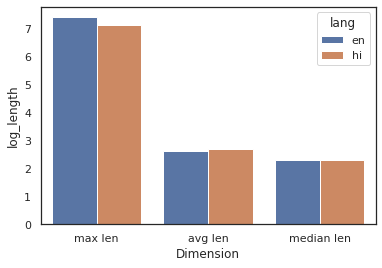

In [ ]:
len_en = [len((sublist).split(" ")) for sublist in df_datasets['clean_en_tok'].tolist()]
len_hi = [len((sublist).split(" ")) for sublist in df_datasets['clean_hi_tok'].tolist()]
print("max len en: ", max(len_en))
print("max len hi: ", max(len_hi))

print("avg len en: ", statistics.mean(len_en))
print("avg len hi: ", statistics.mean(len_hi))

print("med len en: ", statistics.median(len_en))
print("med len hi: ", statistics.median(len_hi))

df_ = pd.DataFrame({'Dimension': ['max len', 'max len', 'avg len', 'avg len', 'median len', 'median len'],
                   'log_length': [math.log(max(len_en)), math.log(max(len_hi)), math.log(statistics.mean(len_en)), math.log(statistics.mean(len_hi)), math.log(statistics.median(len_en)),math.log(statistics.median(len_hi))],
                   'lang': ['en', 'hi', 'en', 'hi', 'en', 'hi']})

#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
sns.barplot(x='Dimension', y='log_length', hue='lang', data=df_)

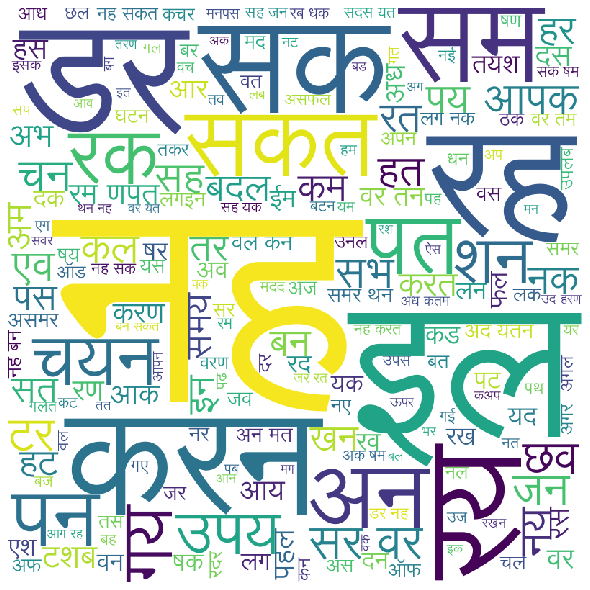

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
# from nltk.tokenize import word_tokenize
import re
from collections import Counter
!wget https://raw.githubusercontent.com/taranjeet/hindi-tokenizer/master/stopwords.txt
!wget https://www.lipikaar.com/sites/www.lipikaar.com/themes/million/images/support/fonts/Devanagari.zip
!unzip Devanagari.zip
stopword=open("stopwords.txt","r")
stop_words=[]

# pre-process stopword
for i in stopword:
  i = re.sub('[\n]', '', i)
  stop_words.append(i)

hi_stopwords = list(set(stop_words))+[".",",","|","?","क","ख","ग","घ","ङ","च","छ","ज","झ","ञ","ट","ठ","ड","ढ","ण","त","थ","द","ध","न","प","फ","ब","भ","म","य","र","ल","व","श","ष","स","ह"]+\
                ["अ","क","आ","का","ॲ","कॅ","ऑ","कॉ","इ","कि","ई","की","उ","कु","ऊ","कू","ऎ","कॆ","ए","के","ऐ","कै","ऒ","कॊ","ओ","को","औ","कौ","ऋ","कृ","ॠ","कॄ","ऌ","कॢ","ॡ","कॣ","अं","कं","अः","कः","क्"]
text = ' '.join(df_datasets['clean_hi_tok'].tolist()[0:140886])
# text = " ".join(text)

wordcloud = WordCloud(font_path='Devanagari/Lohit-Devanagari.ttf',width = 800, height = 800,
                      background_color ='white',
                      stopwords = hi_stopwords,
                      min_font_size = 10).generate(text)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)

plt.show()

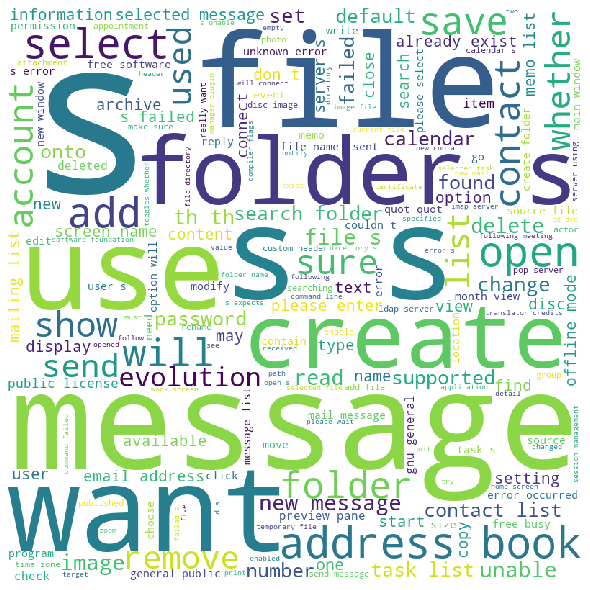

In [ ]:
text = ' '.join(df_datasets['clean_en_tok'].tolist()[0:140886])

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = STOPWORDS,
                      min_font_size = 10).generate(text)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)

plt.show()

### Generating Final Data
Here we generate the token files which are acceptable into Joeynmt NMT.

In [26]:
import os
def create_tok_files(input_df, dataset_name):
    src_tok_file = os.path.join(data_dir, dataset_name + "_tok.en") 
    tgt_tok_file = os.path.join(data_dir, dataset_name + "_tok.hi") 
    if dataset_name !="all":
        src_content = input_df[input_df['type']==dataset_name]['clean_en_tok'].to_list()
        tgt_content = input_df[input_df['type']==dataset_name]['clean_hi_tok'].to_list()
    else:
        src_content = input_df['clean_en_tok'].to_list()
        tgt_content = input_df['clean_hi_tok'].to_list()
    print(f"Creating Source token files: {src_tok_file}")
    print(f"Creating Target token files: {tgt_tok_file}")
    with open(src_tok_file, 'w') as src, open(tgt_tok_file, 'w') as tgt:
        for src_line, tgt_line in zip(src_content, tgt_content):
            src.write((src_line) + "\n")
            tgt.write((tgt_line) + "\n")

In [ ]:
# ℹ️ Loading CSV  "final.csv"
df_datasets = pd.read_csv(data_dir+"/final.csv") 

create_tok_files(df_datasets, "all")
create_tok_files(df_datasets, "train")
create_tok_files(df_datasets, "test")
create_tok_files(df_datasets, "val")

####  HuggingFace Dataset Format 
Save data in to HuggingFace Dataset Format to quickly load it in memory while training

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset_dict = DatasetDict({ 
  "train": Dataset.from_pandas(df_datasets[df_datasets['type']=='train'][['clean_en_tok','clean_hi_tok']]),
  "validation": Dataset.from_pandas(df_datasets[df_datasets['type']=='val'][['clean_en_tok','clean_hi_tok']]),
  "test": Dataset.from_pandas(df_datasets[df_datasets['type']=='test'][['clean_en_tok','clean_hi_tok']])
})

dataset_dict.save_to_disk(data_dir)

### Byte Pair Encoding (BPE) - Learn BPE codes 
⚠️ The below setps are only necessary if we are not running `build_vocab.py` from joeyNMT. 

joeyNMT version 2 executes the below setps inside `build_vocab.py`

In [ ]:
os.environ['NUM_OF_MERGE_OPERATIONS'] = "16000"
os.environ['data_dir'] = data_dir


In [ ]:
! subword-nmt learn-joint-bpe-and-vocab --input $data_dir/all_tok.en $data_dir/all_tok.hi -s $NUM_OF_MERGE_OPERATIONS -o $data_dir/all_bpe.codes --write-vocabulary $data_dir/vocab.en $data_dir/vocab.hi

#### Apply BPE

In [ ]:
! subword-nmt apply-bpe -c $data_dir/all_bpe.codes --vocabulary $data_dir/vocab.en < $data_dir/train_tok.en > $data_dir/train.bpe.en
! subword-nmt apply-bpe -c $data_dir/all_bpe.codes --vocabulary $data_dir/vocab.hi < $data_dir/train_tok.hi > $data_dir/train.bpe.hi

! subword-nmt apply-bpe -c $data_dir/all_bpe.codes --vocabulary $data_dir/vocab.en < $data_dir/val_tok.en > $data_dir/val.bpe.en
! subword-nmt apply-bpe -c $data_dir/all_bpe.codes --vocabulary $data_dir/vocab.hi < $data_dir/val_tok.hi > $data_dir/val.bpe.hi

! subword-nmt apply-bpe -c $data_dir/all_bpe.codes --vocabulary $data_dir/vocab.en < $data_dir/test_tok.en > $data_dir/test.bpe.en
! subword-nmt apply-bpe -c $data_dir/all_bpe.codes --vocabulary $data_dir/vocab.hi < $data_dir/test_tok.hi > $data_dir/test.bpe.hi

#### BPE Codes 

In [ ]:
! wc -l $data_dir/all_bpe.codes

#### BPE Parallel Corpus Sentence Pairs

In [ ]:
! wc -l $data_dir/train.bpe.en $data_dir/train.bpe.hi $data_dir/val.bpe.en $data_dir/val.bpe.hi $data_dir/test.bpe.en $data_dir/test.bpe.hi

### Vocabulary ____ Version1

In [ ]:
# ! sudo chmod 777 joeynmt-1.3/scripts/build_vocab.py
# ! joeynmt-1.3/scripts/build_vocab.py {data_dir}/train.bpe.en {data_dir}/train.bpe.hi --output_path {data_dir}/vocab.txt

In [ ]:
# from pathlib import Path
# config_v1 = """
# name: "v1_enhi_transformer"

# data:
#     src: "en"
#     trg: "hi"
#     train: "{data_dir}/train.bpe"
#     dev:   "{data_dir}/val.bpe"
#     test:   "{data_dir}/test.bpe"
#     level: "bpe"
#     lowercase: False
#     max_sent_length: 60
#     src_vocab: "{data_dir}/vocab.txt"
#     trg_vocab: "{data_dir}/vocab.txt"

# testing:
#     beam_size: 5
#     alpha: 1.0

# training:
#     #load_model: "{model_dir}/latest.ckpt" # if uncommented, load a pre-trained model from this checkpoint
#     random_seed: 42
#     optimizer: "adam"
#     normalization: "tokens"
#     adam_betas: [0.9, 0.999] 
#     scheduling: "plateau"           # TODO: try switching from plateau to Noam scheduling
#     patience: 5                     # For plateau: decrease learning rate by decrease_factor if validation score has not improved for this many validation rounds.
#     learning_rate_factor: 0.5       # factor for Noam scheduler (used with Transformer)
#     learning_rate_warmup: 1000      # warmup steps for Noam scheduler (used with Transformer)
#     decrease_factor: 0.7
#     loss: "crossentropy"
#     learning_rate: 0.0003
#     learning_rate_min: 0.00000001
#     weight_decay: 0.0
#     label_smoothing: 0.1
#     batch_size: 4096
#     batch_type: "token"
#     eval_batch_size: 3600
#     eval_batch_type: "token"
#     batch_multiplier: 1
#     early_stopping_metric: "ppl"
#     epochs: 100                     # TODO: Decrease for when playing around and checking of working. Around 30 is sufficient to check if its working at all
#     validation_freq: 1000          # TODO: Set to at least once per epoch.
#     logging_freq: 100
#     eval_metric: "bleu"
#     model_dir: {model_dir}
#     overwrite: True               # TODO: Set to True if you want to overwrite possibly existing models. 
#     shuffle: True
#     use_cuda: True
#     max_output_length: 130
#     print_valid_sents: [0, 1, 2, 3]
#     keep_best_ckpts: 3
    
# model:
#     initializer: "xavier"
#     bias_initializer: "zeros"
#     init_gain: 1.0
#     embed_initializer: "xavier"
#     embed_init_gain: 1.0
#     tied_embeddings: True
#     tied_softmax: True
#     encoder:
#         type: "transformer"
#         num_layers: 6
#         num_heads: 4             # TODO: Increase to 8 for larger data.
#         embeddings:
#             embedding_dim: 256   # TODO: Increase to 512 for larger data.
#             scale: True
#             dropout: 0.2
#         # typically ff_size = 4 x hidden_size
#         hidden_size: 256         # TODO: Increase to 512 for larger data.
#         ff_size: 1024            # TODO: Increase to 2048 for larger data.
#         dropout: 0.3
#     decoder:
#         type: "transformer"
#         num_layers: 6
#         num_heads: 4              # TODO: Increase to 8 for larger data.
#         embeddings:
#             embedding_dim: 256    # TODO: Increase to 512 for larger data.
#             scale: True
#             dropout: 0.2
#         # typically ff_size = 4 x hidden_size
#         hidden_size: 256         # TODO: Increase to 512 for larger data.
#         ff_size: 1024            # TODO: Increase to 2048 for larger data.
#         dropout: 0.3
# """.format(model_dir=model_dir,data_dir=data_dir)
# with (Path(data_dir) / "config_v1.yaml").open('w') as f:
#     f.write(config_v1)

### Vocabulary ____ Version 2

We will use the [sentencepiece](https://github.com/google/sentencepiece) library to split words into subwords (BPE) according to their frequency in the training corpus.

`build_vocab.py` script will train the BPE model and creates joint vocabulary. It takes the same config file as the joeynmt.

⚠️ Restart the run timee, and next step require high system resources with GPU compute.

In [ ]:
# Clear the memory
# del dataset_dict
# del df_datasets

In [ ]:
# Create the config
config = """
name: "transformer_{datasize}_enhi_bpe"
joeynmt_version: "2.0.0"

data:
    train: "{data_dir}/train_tok"
    dev: "{data_dir}/val_tok"
    test: "{data_dir}/test_tok"
    dataset_type: "plain_ac"
    # dataset_cfg:           # not necessary for manually saved pyarray daraset
    #     name: "en-hi"
    src:
        lang: "en"
        max_length: 60
        lowercase: False
        level: "bpe"
        voc_file: "{data_dir}/vocab.en"
        tokenizer_type: "subword-nmt"
        tokenizer_cfg:
            codes: "{data_dir}/en.bpe.codes"
            num_merges: 16000
            # model_file: "{data_dir}/sp_en.model"
            pretokenizer: "moses"

    trg:
        lang: "hi"
        max_length: 60
        lowercase: False
        level: "bpe"
        voc_file: "{data_dir}/vocab.hi"
        tokenizer_type: "subword-nmt"
        tokenizer_cfg:
            codes: "{data_dir}/hi.bpe.codes"
            num_merges: 16000
            # model_file: "{data_dir}/sp_hi.model"
            pretokenizer: "none"

""".format(data_dir=data_dir,datasize=DATASIZE)
with open(f"{data_dir}/config.yaml",'w') as f:
    f.write(config)

In [ ]:
# HuggingFace Dataset load 
# # Create the config
# config = """
# name: "transformer_{datasize}_enhi_bpe"
# joeynmt_version: "2.0.0"

# data:
#     train: "{data_dir}/train"
#     dev: "{data_dir}/validation"
#     test: "{data_dir}/test"
#     dataset_type: "huggingface"
#     #dataset_cfg:           # not necessary for manually saved pyarray daraset
#     #    name: "en-hi"
#     src:
#         lang: "en"
#         max_length: 100
#         lowercase: False
#         level: "bpe"
#         voc_file: "{data_dir}/vocab.en"
#         tokenizer_type: "subword-nmt"
#         tokenizer_cfg:
#             codes: "{data_dir}/all_bpe.codes.en"
#             num_merges: 32000
#             pretokenizer: "moses"

#     trg:
#         lang: "hi"
#         max_length: 100
#         lowercase: False
#         level: "bpe"
#         voc_file: "{data_dir}/vocab.hi"
#         tokenizer_type: "subword-nmt"
#         tokenizer_cfg:
#             codes: "{data_dir}/all_bpe.codes.hi"
#             num_merges: 32000
#             pretokenizer: "moses"

# """.format(data_dir=data_dir,datasize=DATASIZE)
# with open(f"{data_dir}/config.yaml",'w') as f:
#     f.write(config)

Now run the build_vocab.py from base joeynmt and generate bpe (byte pair encodings). as Hindi and English are very different languages and have no syntactical similarity we will not be using --joint flag.

In [ ]:
!python build_vocab.py {data_dir}/config.yaml 

### Training bpe...
100%|████████████████████████████████████| 16000/16000 [00:24<00:00, 665.49it/s]
### Applying bpe...
### Building vocab...
### Done.
### Training bpe...
100%|████████████████████████████████████| 16000/16000 [00:28<00:00, 554.10it/s]
### Applying bpe...
### Building vocab...
### Done.


The generated vocabulary looks like this:

In [45]:
!wc -l {data_dir}/vocab.hi {data_dir}/vocab.en
!tail -10 {data_dir}/vocab.hi

 16170 /content/drive/MyDrive/data/datasets_enhi_100/vocab.hi
 16017 /content/drive/MyDrive/data/datasets_enhi_100/vocab.en
 32187 total
यशुदा
शत्र@@
श्वत
सतर्@@
सांके@@
ॐ@@
क़
ख़@@
ग़@@
य़@@


### Configuration ___ Version 2

Joey NMT reads model and training hyperparameters from a configuration file. We're generating this now to configure paths in the appropriate places.

The configuration below builds a Transformer model with different embeddings for source and target language on the base of the BPE vocabularies created above.

In [ ]:

config += """
active_learning:
    query_size: 10000
    interactive: False
    pool_size: 6
    batch_size: 256
    num_workers: 4
    num_queries: 5
    al_percent : 30
    query_strategy: "margin"
    epoch: 5 

testing:
    n_best: 1
    beam_size: 5
    beam_alpha: 1.0
    batch_size: 1024
    batch_type: "token"
    max_output_length: 130
    eval_metrics: ["bleu"]
    return_prob: "none"
    return_attention: False
    sacrebleu_cfg:
        tokenize: "13a"
        lowercase: False

training:
    #load_model: "{model_dir}/{name}_transformer_{tag}/best.ckpt"
    #reset_best_ckpt: False
    #reset_scheduler: False
    #reset_optimizer: False
    #reset_iter_state: False
    random_seed: 42
    optimizer: "adam"
    normalization: "tokens"
    adam_betas: [0.9, 0.999] 
    scheduling: "plateau"            # Try switching to Elan scheduling
    learning_rate_decay_length: 2500 # number of steps to reduce by the decay factor for Elan method
    learning_rate_peak: 0.005  # peak for Elan scheduler (default: 1)
    learning_rate_warmup: 1000  # warmup steps for Elan scheduler
    learning_rate_factor: 0.5       # factor for Noam scheduler (used with Transformer)
    patience: 5
    decrease_factor: 0.7
    loss: "crossentropy"
    learning_rate: 0.0003
    learning_rate_min: 0.00000001
    weight_decay: 0.0
    label_smoothing: 0.1
    batch_size: 4096
    batch_type: "token"
    batch_multiplier: 1
    early_stopping_metric: "ppl"
    epochs: 20 # TODO: Decrease for when playing around and checking of working. Around 30 is sufficient to check if its working at all
    validation_freq: 1000 # 4000 # Decrease this for testing
    logging_freq: 100
    model_dir: "{model_dir}/{name}_transformer_{tag}"
    overwrite: False
    shuffle: True
    use_cuda: True
    print_valid_sents: [0, 1, 2, 3]
    keep_best_ckpts: 3

model:
    initializer: "xavier"
    bias_initializer: "zeros"
    init_gain: 1.0
    embed_initializer: "xavier"
    embed_init_gain: 1.0
    tied_embeddings: False
    tied_softmax: True
    encoder:
        type: "transformer"
        num_layers: 6
        num_heads: 4
        embeddings:
            embedding_dim: 256
            scale: True
            dropout: 0.2
        # typically ff_size = 4 x hidden_size
        hidden_size: 256
        ff_size: 1024
        dropout: 0.3
        layer_norm: "pre"
    decoder:
        type: "transformer"
        num_layers: 6
        num_heads: 4
        embeddings:
            embedding_dim: 256
            scale: True
            dropout: 0.2
        # typically ff_size = 4 x hidden_size
        hidden_size: 256
        ff_size: 1024
        dropout: 0.3
        layer_norm: "pre"

""".format(model_dir=model_dir,name="enhi",tag="t1_baseline")
with open(f"{data_dir}/config.yaml",'w') as f:
    f.write(config)

We performed random optimisation based on below set of hyper-parameters.
 1. dropout
 2. label smoothing
 3. layer normalization
 4. tied embeddings
 5. tied softmax
 6. weight decay
 7. learning rate warmup
 8. batch multiplier (gradient accumulation)
 9. early stopping with patience
 10. fp16 (half-precision)
 11. label smoothing
 12. beam alpha (length penalty)
 13. repetition penalty
 14. ngram blocker
 15. n best outputs


We also changed few more model parameters to understand the model better.
 - architecture size: more layers, more heads, etc.
 - Try different initialization
 - Change training hyper params:
   - bigger batch size, different batch type
   - different optimizer
   - different learning rate scheduler

## Model Training

### Tensorboard
We'll use TensorBoard to visualize the training progress on the go. This requires enabling Cookies in the browser.

TensorBoard will be empty at first.
While the model is training, click the refresh button on the top right of the board to track how the model is doing.

In [ ]:
!echo {model_dir}
!echo {data_dir}

/content/drive/MyDrive//models/v1_enhi_100_transformer
/content/drive/MyDrive//data/datasets_enhi_100


In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {model_dir}/enhi_transformer_t1/tensorboard

### Run training
⏳ This will take a while. Model parameters will be stored on mounted google drive. The log reports the training process, look out for the prints of example translations and the BLEU evaluation scores to get an impression of the current quality.

> ⛔ If you execute this twice, you might get an error that the model directory already exists. You can specify in the configuration to overwrite it, or delete it manually (`!rm -r {model_dir}`).

In [14]:
!python main.py active_learning {data_dir}/baseline_config.yaml

2022-09-15 09:35:23,608 - INFO - joeynmt.training - 	Reference:  अभिनय , गति संचालन और मूकाभिनय
2022-09-15 09:35:23,608 - INFO - joeynmt.training - 	Hypothesis: कार्य , गति और आईएमई
2022-09-15 09:35:23,609 - INFO - joeynmt.training - Example #3
2022-09-15 09:35:23,609 - DEBUG - joeynmt.training - 	Tokenized source:     ['speech', 'and', 'voice', 'training']
2022-09-15 09:35:23,609 - DEBUG - joeynmt.training - 	Tokenized reference:  ['भाषण', 'शैली', 'और', 'वा@@', 'क्', 'प्रशिक्षण']
2022-09-15 09:35:23,609 - DEBUG - joeynmt.training - 	Tokenized hypothesis: ['भाषण', 'और', 'आवाज', 'प्रशिक्षण', '</s>']
2022-09-15 09:35:23,626 - INFO - joeynmt.training - 	Source:     speech and voice training
2022-09-15 09:35:23,626 - INFO - joeynmt.training - 	Reference:  भाषण शैली और वाक् प्रशिक्षण
2022-09-15 09:35:23,626 - INFO - joeynmt.training - 	Hypothesis: भाषण और आवाज प्रशिक्षण
2022-09-15 09:35:35,250 - INFO - joeynmt.training - Epoch  20, Step:   281100, Batch Loss:     2.098331, Batch Acc: 0.0043

In [31]:
!python main.py active_learning {data_dir}/margin_config.yaml

2022-09-16 13:56:08,121 - INFO - joeynmt.training - Epoch   1, Step:   264200, Batch Loss:     2.647632, Batch Acc: 0.004381, Tokens per Sec:     5079, Lr: 0.000035
2022-09-16 13:56:31,218 - INFO - joeynmt.training - Epoch   1, Step:   264300, Batch Loss:     2.585308, Batch Acc: 0.004668, Tokens per Sec:     4897, Lr: 0.000035
2022-09-16 13:56:54,022 - INFO - joeynmt.training - Epoch   1, Step:   264400, Batch Loss:     2.546415, Batch Acc: 0.004083, Tokens per Sec:     5080, Lr: 0.000035
2022-09-16 13:57:16,810 - INFO - joeynmt.training - Epoch   1, Step:   264500, Batch Loss:     2.468932, Batch Acc: 0.004131, Tokens per Sec:     4972, Lr: 0.000035
2022-09-16 13:57:39,692 - INFO - joeynmt.training - Epoch   1, Step:   264600, Batch Loss:     2.529605, Batch Acc: 0.005020, Tokens per Sec:     5032, Lr: 0.000035
2022-09-16 13:58:02,560 - INFO - joeynmt.training - Epoch   1, Step:   264700, Batch Loss:     2.460216, Batch Acc: 0.004899, Tokens per Sec:     5044, Lr: 0.000035
2022-09-16

In [30]:
!python main.py active_learning {data_dir}/least_confidence_config.yaml

2022-09-16 11:55:11,985 - INFO - joeynmt.training - 	Reference:  भाषण शैली और वाक् प्रशिक्षण
2022-09-16 11:55:11,986 - INFO - joeynmt.training - 	Hypothesis: भाषण और आवाज प्रशिक्षण
2022-09-16 11:55:23,887 - INFO - joeynmt.training - Epoch   1, Step:   275100, Batch Loss:     2.575066, Batch Acc: 0.005007, Tokens per Sec:     9680, Lr: 0.000035
2022-09-16 11:55:35,733 - INFO - joeynmt.training - Epoch   1, Step:   275200, Batch Loss:     2.583625, Batch Acc: 0.004339, Tokens per Sec:     9728, Lr: 0.000035
2022-09-16 11:55:47,570 - INFO - joeynmt.training - Epoch   1, Step:   275300, Batch Loss:     2.597494, Batch Acc: 0.004560, Tokens per Sec:     9652, Lr: 0.000035
2022-09-16 11:55:59,338 - INFO - joeynmt.training - Epoch   1, Step:   275400, Batch Loss:     2.355397, Batch Acc: 0.004010, Tokens per Sec:     9706, Lr: 0.000035
2022-09-16 11:56:11,117 - INFO - joeynmt.training - Epoch   1, Step:   275500, Batch Loss:     2.507886, Batch Acc: 0.004060, Tokens per Sec:     9787, Lr: 0.0

In [29]:
!python main.py train {data_dir}/full_config.yaml

2022-09-15 20:21:58,940 - INFO - joeynmt.training - 	Hypothesis: भाषण और आवाज प्रशिक्षण
2022-09-15 20:22:14,081 - INFO - joeynmt.training - Epoch   5, Step:   278100, Batch Loss:     2.572317, Batch Acc: 0.004519, Tokens per Sec:     6884, Lr: 0.000035
2022-09-15 20:22:28,985 - INFO - joeynmt.training - Epoch   5, Step:   278200, Batch Loss:     2.733479, Batch Acc: 0.004499, Tokens per Sec:     7561, Lr: 0.000035
2022-09-15 20:22:43,790 - INFO - joeynmt.training - Epoch   5, Step:   278300, Batch Loss:     2.668473, Batch Acc: 0.004343, Tokens per Sec:     7450, Lr: 0.000035
2022-09-15 20:22:58,892 - INFO - joeynmt.training - Epoch   5, Step:   278400, Batch Loss:     2.440015, Batch Acc: 0.004810, Tokens per Sec:     7379, Lr: 0.000035
2022-09-15 20:23:14,346 - INFO - joeynmt.training - Epoch   5, Step:   278500, Batch Loss:     2.370182, Batch Acc: 0.005294, Tokens per Sec:     7102, Lr: 0.000035
2022-09-15 20:23:29,158 - INFO - joeynmt.training - Epoch   5, Step:   278600, Batch Lo

### Continue training after interruption
To continue after an interruption, the configuration needs to be modified in the following places:

- `load_model` to point to the checkpoint to load.
- `reset_*` options (must be False) to resume the previous session.
- `model_dir` to create a new directory.

In [ ]:
resume_config = config\
  .replace('#load_model:', 'load_model:')\
  .replace('#reset_best_ckpt: False', 'reset_best_ckpt: False')\
  .replace('#reset_scheduler: False', 'reset_scheduler: False')\
  .replace('#reset_optimizer: False', 'reset_optimizer: False')\
  .replace('#reset_iter_state: False', 'reset_iter_state: False')\
  .replace('epochs: 20', 'epochs: 1')\
  .replace(f'model_dir: "{model_dir}/enhi_transformer_t1_baseline"', f'model_dir: "{model_dir}/enhi_transformer_t1_baseline_resume"')

with open(f"{data_dir}/resume_config.yaml",'w') as f:
    f.write(resume_config)

In [ ]:
!ls -l {data_dir}/resume_config.yaml

-rw------- 1 root root 3813 Aug 22 23:24 /content/drive/MyDrive/datasets_enhi_10/resume_config.yaml


In [ ]:
!python -m joeynmt train {data_dir}/resume_config.yaml

> 💡 It starts counting the epochs from the beginning again, but step numbers should continue from before and we should find a "reloading" line in the training log.


We can plot all resumed sessions together in a sigle tensorboard by creating a symlink:

In [ ]:
!mkdir /content/drive/MyDrive/models/logdir
!cd /content/drive/MyDrive/models/logdir && ln -s ../tatoeba_deen/tensorboard tatoeba_deen
!cd /content/drive/MyDrive/models/logdir && ln -s ../tatoeba_deen_resume/tensorboard tatoeba_deen_resume

In [ ]:
# Reload the TensorBoard notebook extension.
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/models/logdir

## Evaluation


The `test` mode can be used to translate (and evaluate on) the test set specified in the configuration. We usually do this only once after we've tuned hyperparameters on the dev set.

In [ ]:
!python main.py test {data_dir}/baseline_config.yaml --ckpt {model_dir}/enhi_transformer_t1_baseline/180000.ckpt

2022-09-16 04:13:13,927 - INFO - root - Hello! This is Joey-NMT (version 2.0.0).
2022-09-16 04:13:13,929 - INFO - joeynmt.data - Building tokenizer...
2022-09-16 04:13:14,025 - INFO - joeynmt.tokenizers - en tokenizer: SubwordNMTTokenizer(level=bpe, lowercase=False, normalize=False, filter_by_length=(-1, 60), pretokenizer=moses, tokenizer=BPE, separator=@@, dropout=0.0)
2022-09-16 04:13:14,025 - INFO - joeynmt.tokenizers - hi tokenizer: SubwordNMTTokenizer(level=bpe, lowercase=False, normalize=False, filter_by_length=(-1, 60), pretokenizer=none, tokenizer=BPE, separator=@@, dropout=0.0)
2022-09-16 04:13:14,025 - INFO - joeynmt.data - Building vocabulary...
2022-09-16 04:13:17,614 - INFO - joeynmt.data - Loading dev set...
2022-09-16 04:13:23,329 - INFO - joeynmt.data - Loading test set...
2022-09-16 04:13:28,794 - INFO - joeynmt.data - Data loaded.
2022-09-16 04:13:28,794 - INFO - joeynmt.helpers - Train dataset: None
2022-09-16 04:13:28,795 - INFO - joeynmt.helpers - Valid dataset: Pl

In [ ]:
!python main.py test {data_dir}/margin_config.yaml --ckpt {model_dir}/enhi_transformer_t1_margin/

In [ ]:
!python main.py test {data_dir}/least_condifence_config.yaml --ckpt {model_dir}/enhi_transformer_t1_least_confidence/273000.ckpt

In [ ]:
!python main.py test {data_dir}/fully_trained_config.yaml --ckpt {model_dir}/enhi_transformer_t1_full/278000.ckpt

2022-09-16 04:56:45,337 - INFO - root - Hello! This is Joey-NMT (version 2.0.0).
2022-09-16 04:56:45,338 - INFO - joeynmt.data - Building tokenizer...
2022-09-16 04:56:45,438 - INFO - joeynmt.tokenizers - en tokenizer: SubwordNMTTokenizer(level=bpe, lowercase=False, normalize=False, filter_by_length=(-1, 60), pretokenizer=moses, tokenizer=BPE, separator=@@, dropout=0.0)
2022-09-16 04:56:45,438 - INFO - joeynmt.tokenizers - hi tokenizer: SubwordNMTTokenizer(level=bpe, lowercase=False, normalize=False, filter_by_length=(-1, 60), pretokenizer=none, tokenizer=BPE, separator=@@, dropout=0.0)
2022-09-16 04:56:45,438 - INFO - joeynmt.data - Building vocabulary...
2022-09-16 04:56:49,044 - INFO - joeynmt.data - Loading dev set...
2022-09-16 04:56:54,763 - INFO - joeynmt.data - Loading test set...
2022-09-16 04:57:00,221 - INFO - joeynmt.data - Data loaded.
2022-09-16 04:57:00,222 - INFO - joeynmt.helpers - Train dataset: None
2022-09-16 04:57:00,222 - INFO - joeynmt.helpers - Valid dataset: Pl

### Human in the loop

In `active_learning` mode we can annotate certain samples if we feel fit that the translation is sub-optimum. It is interactive and takes prompts to translate interactively.

Let's Translate a few examples to provide better results for active learning.


In [34]:
config = " ".join(open(f"{data_dir}/least_confidence.yaml").readlines())
resume_config = config\
  .replace(f'interactive: False', f'interactive: True')\
  .replace(f'model_dir: "{model_dir}/enhi_transformer_t1_least_confidence"', f'model_dir: "{model_dir}/enhi_transformer_t1_least_confidence_interactive"')


with open(f"{data_dir}/least_confidence_interactive.yaml",'w') as f:
    f.write(resume_config)

In [ ]:
!python main.py active_learning {data_dir}/least_confidence_interactive.yaml

2022-09-16 16:19:50,402 - INFO - root - Hello! This is Joey-NMT (version 2.0.0).
2022-09-16 16:19:50,403 - INFO - joeynmt.helpers -                           cfg.name : transformer_100_enhi_bpe
2022-09-16 16:19:50,403 - INFO - joeynmt.helpers -                cfg.joeynmt_version : 2.0.0
2022-09-16 16:19:50,403 - INFO - joeynmt.helpers -                     cfg.data.train : /content/drive/MyDrive/data/datasets_enhi_100/train_tok
2022-09-16 16:19:50,403 - INFO - joeynmt.helpers -                       cfg.data.dev : /content/drive/MyDrive/data/datasets_enhi_100/val_tok
2022-09-16 16:19:50,403 - INFO - joeynmt.helpers -                      cfg.data.test : /content/drive/MyDrive/data/datasets_enhi_100/test_tok
2022-09-16 16:19:50,403 - INFO - joeynmt.helpers -              cfg.data.dataset_type : plain_ac
2022-09-16 16:19:50,404 - INFO - joeynmt.helpers -                  cfg.data.src.lang : en
2022-09-16 16:19:50,404 - INFO - joeynmt.helpers -            cfg.data.src.max_length : 60
2022

### Translate to Hindi

The `translate` mode is more interactive and takes prompts to translate interactively.

Let's Translate a few examples!

In [ ]:
!python main.py translate {data_dir}/margin_config.yaml --ckpt {model_dir}/enhi_transformer_t1_margin/

You can also get the n-best hypotheses (up to the size of the beam, in our example 5), not only the highest scoring one. The better your model gets, the more interesting should the alternatives be.



In [ ]:
nbest_config = config.replace('n_best: 1', 'n_best: 5')\
  .replace('#return_prob: "hyp"', 'return_prob: "hyp"')

with (Path(data_dir) / "nbest_config.yaml").open('w') as f:
    f.write(nbest_config)

In [ ]:
!python -m joeynmt translate {data_dir}/margin_config.yaml --ckpt {model_dir}/enhi_transformer_t1_margin/

## Appendix:

### plotting learning curves

`plot_validations.py` script will generate validation learning curves.

We resumed the training once, so first we concatenate the validations.txt file, and use the concatenated validations.txt for plotting.

In [ ]:
!cat {model_dir}/validations.txt {model_dir}_resume/validations.txt > {model_dir}_resume/_validations.txt
!mv {model_dir}_resume/validations.txt resumed_valudations.txt
!mv {model_dir}_resume/_validations.txt {model_dir}_resume/validations.txt

In [ ]:
!python /content/drive/MyDrive/joeynmt/scripts/plot_validations.py {model_dir}_resume --output_path {model_dir}_resume/plot.png

In [ ]:
from IPython.display import Image

Image(f"{model_dir}_resume/plot.png")

In [5]:
%cd joeynmt

/content/joeynmt


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import re, json

def get_bleu(data):
    lst=re.findall(re.compile('\(greedy\)\sbleu:\s+\d+.\d+'),data)
    margin_bleu=[]
    for ele in lst:
        value=re.search('\d+.\d+',ele)[0]
        margin_bleu.append(float(value))
    return margin_bleu
def get_ppl(data):
    lst=re.findall(re.compile('ppl:\s+\d+.\d+'),data)
    margin_bleu=[]
    for ele in lst:
        value=re.search('\d+.\d+',ele)[0]
        margin_bleu.append(float(value))
    return margin_bleu
def get_steps(data):
    pat='Epoch\s+\d{1,2},\s+Step:\s+\d+'
    lst=re.findall(re.compile(pat),data)
    lst=[int(i.split()[-1]) for i in lst]
    start,end=lst[0],lst[-1]
    print(start,end)
    steps=[i for i in range(start,end,1000)]
    if end%1000!=0:
        steps.append(end)
    return steps
def get_loss(data):
    pat='\,\sloss:\s+\d+.\d+'
    lst=re.findall(re.compile(pat),data)
    lst=[float(i.split()[-1]) for i in lst]
    return lst

In [19]:
!rm -rf logs/.ipynb_checkpoints

In [18]:
import os
os.listdir('logs/')

['.ipynb_checkpoints',
 'baseline.log',
 'least_confidence.log',
 'fully_train.log',
 'margin.log']

In [20]:
files=[file for file in os.listdir('logs/') if file.endswith('.log')]

all_data=[]
for file in files:
    value_dict={}
    with open('logs/'+file,encoding='utf-8') as f:
        data = f.read()
    steps=get_steps(data)
    score=get_bleu(data)
    ppl=get_ppl(data)
    loss=get_loss(data)
    value_dict[Path(file).stem]={'score':score,'steps':steps,'ppl':ppl,'loss':loss}
    print(file,len(score),len(steps),len(ppl),len(loss))
    assert len(score)==len(steps)==len(ppl)
    with open(Path(file).stem+'_dict.json','w') as f:
        json.dump(value_dict,f)
    all_data.append(value_dict)

100 281300
baseline.log 283 283 283 283
180100 275800
least_confidence.log 97 97 97 97
180100 279000
fully_train.log 99 99 99 99
180100 265000
margin.log 85 85 85 85


### Plot the bleu and ppl

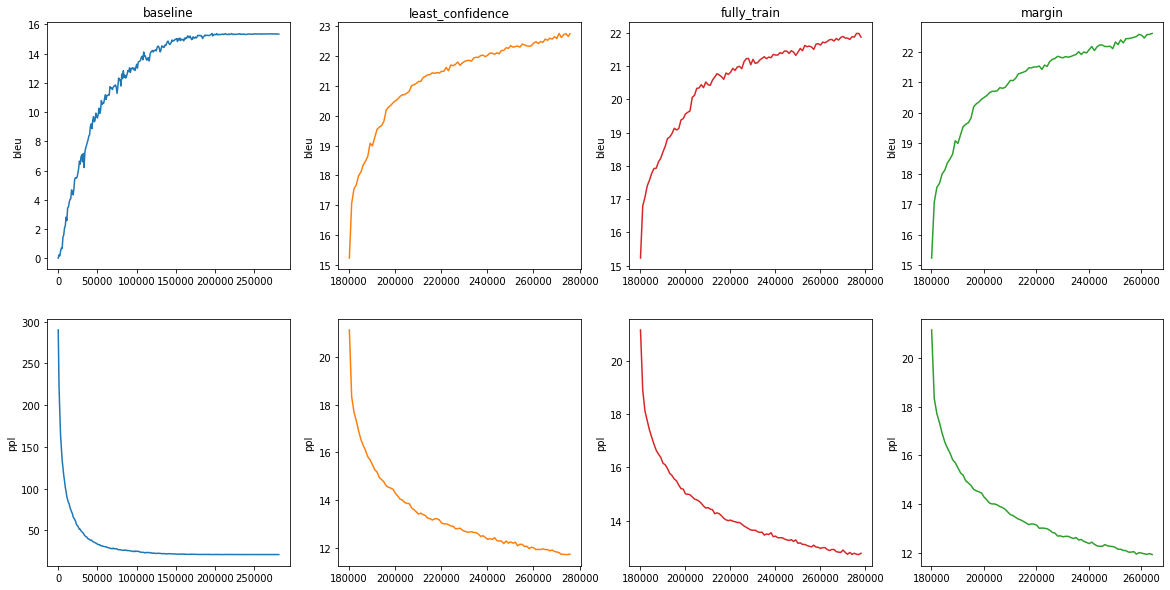

In [21]:
#to Plot the bleu and ppl
fig, axs = plt.subplots(2, 4,figsize=(20,10))
color=['blue','orange','red','green']
for i,value in enumerate(all_data):
    key=list(value.keys())[0]
    axs[0, i].set_title(key)
    axs[0, i].plot(value[key]['steps'],value[key]['score'],'tab:'+color[i])
    axs[0, i].set( ylabel='bleu')
    axs[1, i].plot(value[key]['steps'],value[key]['ppl'], 'tab:'+color[i])
    axs[1, i].set( ylabel='ppl')

### Plot the Training loss

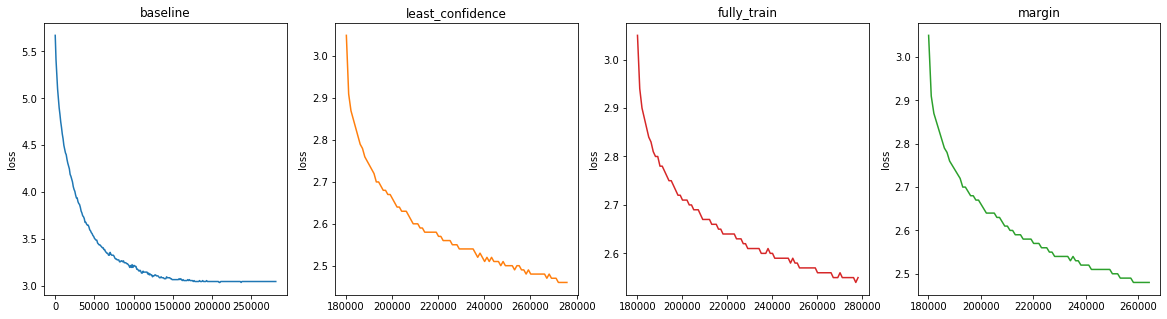

In [22]:
#to Plot the loss function
fig, axs = plt.subplots(1, 4,figsize=(20,5))
color=['blue','orange','red','green']
for i,value in enumerate(all_data):
    key=list(value.keys())[0]
    axs[i].set_title(key)
    axs[i].plot(value[key]['steps'],value[key]['loss'],'tab:'+color[i])
    axs[i].set( ylabel='loss')

### BLEU Score comparision

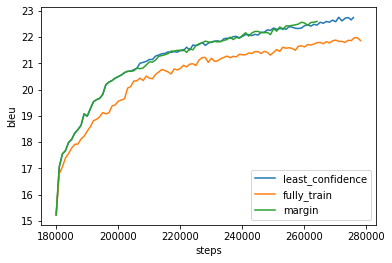

In [23]:

for i,value in enumerate(all_data):
    key=list(value.keys())[0]
    if key!='baseline':
        plt.plot(value[key]['steps'],value[key]['score'], label = key)
    else:
        pass

plt.legend()
plt.ylabel('bleu')
plt.xlabel('steps')
plt.show()

### Sentence length based evaluation of BLEU Score

In [11]:
df_datasets = pd.read_csv(data_dir+"/final.csv") 

In [12]:
df_datasets

,clean_en_tok,clean_hi_tok,en_tok_len,hi_tok_len,type
0,give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,6,8,train
1,accerciser accessibility explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक,3,3,train
2,the default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लगइन खाका,8,7,train
3,the default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका,8,7,train
4,a list of plugins that are disabled by default,उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष...,9,12,train
...,...,...,...,...,...
1635473,"the former deputy chief minister , narhari ami...",विस चुनाव से पहले कांग्रेस छोड़ भाजपा में आए प...,29,22,test
1635474,this ministry expansion is being seen as modis...,इस मंत्रिमंडल विस्तार को मोदी की लोकसभा चुनाव ...,14,17,test
1635475,he has been travelling around a lot to promote...,वह लंबे समय से राजनीतिक प्रवास कर रहे हैं ।,12,9,test
1635476,"after doing a tour of the five states , he wil...",पांच राज्यों के विस चुनाव बाद और ज्यादा आक्राम...,17,16,test


In [15]:
df_datasets_lt_10 = df_datasets[(df_datasets['en_tok_len'] <= 10 ) & (df_datasets['hi_tok_len'] <= 10)]
df_datasets_gt_10_lt_60 = df_datasets[((df_datasets['en_tok_len'] > 10 ) & (df_datasets['hi_tok_len'] > 10)) & ((df_datasets['en_tok_len'] <= 60 ) & (df_datasets['hi_tok_len'] <= 60)) ]
df_datasets_gt_60 = df_datasets[(df_datasets['en_tok_len'] > 60 ) & (df_datasets['hi_tok_len'] > 60)]


In [18]:
df_datasets_lt_10 = df_datasets_lt_10[(df_datasets_lt_10['type'] == "test" )]
df_datasets_gt_10_lt_60 = df_datasets_gt_10_lt_60[(df_datasets_gt_10_lt_60['type'] == "test" )]
df_datasets_gt_60 = df_datasets_gt_60[(df_datasets_gt_60['type'] == "test" )]

In [ ]:
df_datasets_lt_10["type"] = "test_lt_10"
df_datasets_gt_10_lt_60["type"] = "test_gt_10_lt_60"
df_datasets_gt_60["type"] = "test_gt_60"

In [22]:
print(df_datasets_lt_10.shape,df_datasets_gt_10_lt_60.shape,df_datasets_gt_60.shape)

(9378, 5) (27539, 5) (124, 5)


In [27]:
create_tok_files(df_datasets_lt_10, "test_lt_10")
create_tok_files(df_datasets_gt_10_lt_60, "test_gt_10_lt_60")
create_tok_files(df_datasets_gt_60, "test_gt_60")

Creating Source token files: /content/drive/MyDrive/data/datasets_enhi_100/test_lt_10_tok.en
Creating Target token files: /content/drive/MyDrive/data/datasets_enhi_100/test_lt_10_tok.hi
Creating Source token files: /content/drive/MyDrive/data/datasets_enhi_100/test_gt_10_lt_60_tok.en
Creating Target token files: /content/drive/MyDrive/data/datasets_enhi_100/test_gt_10_lt_60_tok.hi
Creating Source token files: /content/drive/MyDrive/data/datasets_enhi_100/test_gt_60_tok.en
Creating Target token files: /content/drive/MyDrive/data/datasets_enhi_100/test_gt_60_tok.hi


In [36]:
config = " ".join(open(f"{data_dir}/fully_trained_config.yaml").readlines())
resume_config = config\
  .replace(f'test: "{data_dir}/test_tok"', f'test: "{data_dir}/test_lt_10_tok"')

with open(f"{data_dir}/fully_trained_config_lt_10_tok.yaml",'w') as f:
    f.write(resume_config)

In [41]:
!python main.py test {data_dir}/fully_trained_config.yaml --ckpt {model_dir}/enhi_transformer_t1_full/278000.ckpt

2022-09-16 09:16:44,320 - INFO - root - Hello! This is Joey-NMT (version 2.0.0).
2022-09-16 09:16:44,788 - INFO - joeynmt.data - Building tokenizer...
2022-09-16 09:16:45,489 - INFO - joeynmt.tokenizers - en tokenizer: SubwordNMTTokenizer(level=bpe, lowercase=False, normalize=False, filter_by_length=(-1, 60), pretokenizer=moses, tokenizer=BPE, separator=@@, dropout=0.0)
2022-09-16 09:16:45,489 - INFO - joeynmt.tokenizers - hi tokenizer: SubwordNMTTokenizer(level=bpe, lowercase=False, normalize=False, filter_by_length=(-1, 60), pretokenizer=none, tokenizer=BPE, separator=@@, dropout=0.0)
2022-09-16 09:16:45,489 - INFO - joeynmt.data - Building vocabulary...
2022-09-16 09:16:52,456 - INFO - joeynmt.data - Loading dev set...
2022-09-16 09:17:00,913 - INFO - joeynmt.data - Loading test set...
2022-09-16 09:17:08,154 - INFO - joeynmt.data - Data loaded.
2022-09-16 09:17:08,154 - INFO - joeynmt.helpers - Train dataset: None
2022-09-16 09:17:08,154 - INFO - joeynmt.helpers - Valid dataset: Pl

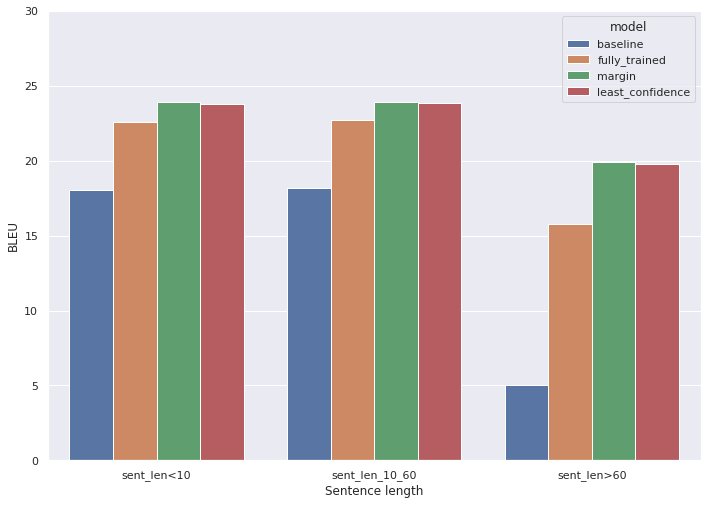

In [43]:
df_ = pd.DataFrame({'Sentence length': ['sent_len<10', 'sent_len<10', 'sent_len<10', 'sent_len<10', 'sent_len_10_60', 'sent_len_10_60', 'sent_len_10_60', 'sent_len_10_60', 'sent_len>60', 'sent_len>60', 'sent_len>60', 'sent_len>60'],
                   'BLEU': [18.06, 22.56, 23.89, 23.78, 18.16, 22.71, 23.90, 23.84, 5.06, 15.80, 19.89, 19.78],
                   'model': ['baseline', 'fully_trained', 'margin', 'least_confidence', 'baseline', 'fully_trained', 'margin', 'least_confidence', 'baseline', 'fully_trained', 'margin', 'least_confidence']})

#set seaborn plotting aesthetics
# sns.set(style='white')

#create grouped bar chart
import matplotlib.pyplot as plt

plt.ylim(0, 30)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='Sentence length', y='BLEU', hue='model', data=df_)